In [1]:
%load_ext lab_black

In [2]:
import math
import os
import random
from collections import defaultdict
from datetime import datetime
from io import TextIOWrapper
from pathlib import Path
from typing import Callable, List, Sequence, Tuple

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import mobilenet_v2
from torchvision.models.detection import KeypointRCNN, keypointrcnn_resnet50_fpn
from torchvision.ops import MultiScaleRoIAlign
from tqdm import tqdm

import utils

import matplotlib.pyplot as plt
from PIL import Image

BASELINE = True
MODEL = "keypointrcnn_resnet50_fpn_finetune"
DATA_DIR = Path("data/ori")
FOLD = 1
NUM_FOLDS = 5
START_EPOCH = 1
NUM_EPOCHS = 200
SAM = False
LR = 1e-4
BATCH_SIZE = 2
SEED = 20210304

In [3]:
len(list(Path("data/ori/train_imgs/").glob("*.jpg"))), len(list(Path("data/ori/test_imgs/").glob("*.jpg"))),

(4195, 1600)

In [4]:
edges = [
    (0, 1),
    (0, 2),
    (2, 4),
    (1, 3),
    (6, 8),
    (8, 10),
    (5, 7),
    (7, 9),
    (11, 13),
    (13, 15),
    (12, 14),
    (14, 16),
    (5, 6),
    (15, 22),
    (16, 23),
    (11, 21),
    (21, 12),
    (20, 21),
    (5, 20),
    (6, 20),
    (17, 6),
    (17, 5),
]

In [5]:
df = pd.read_csv("data/ori/train_df.csv")
keypoints = df.iloc[0, 1:].values.reshape(-1, 2)
keypoints = keypoints.astype(np.int64)
keypoint_names = df.columns[1:].tolist()

In [6]:
class KeypointDataset(Dataset):
    def __init__(self, image_files: os.PathLike, df: os.PathLike = None, transforms: Sequence[Callable] = None):
        self.image_files = image_files
        self.df = df
        self.transforms = transforms

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index: int):
        image_file = self.image_files[index]
        image = imageio.imread(image_file)

        if self.df is not None:
            labels = np.array([1])
            keypoints = self.df[index, 1:].reshape(-1, 2).astype(np.int64)
            x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
            x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
            boxes = np.array([[x1, y1, x2, y2]], dtype=np.int64)

            targets = {
                "image": image,
                "bboxes": boxes,
                "labels": labels,
                "keypoints": keypoints,
            }
            targets = self.transforms(**targets)

            image = targets["image"]
            # image = image / 255.0 # 255으로 나눠주면 안됨. ToTensorV2에서 255로 나눠주나봄?

            targets = {
                "labels": torch.as_tensor(targets["labels"], dtype=torch.int64),
                "boxes": torch.as_tensor(targets["bboxes"], dtype=torch.float32),
                "keypoints": torch.as_tensor(
                    np.concatenate([targets["keypoints"], np.ones((24, 1))], axis=1)[np.newaxis],
                    dtype=torch.float32,
                ),
            }

            return image_file, image, targets
        else:
            targets = self.transforms(image=image)
            image = targets["image"]

            return image_file, image


def collate_fn(batch: torch.Tensor) -> Tuple:
    return tuple(zip(*batch))

In [7]:
def load_dataset(fold):
    transform_train = A.Compose(
        [
            # Crop으로 이미지 크기는 1100, 900이 되는 것
            A.Crop(400, 100, 1500, 1000),
            # TODO 이미 1100x900 이므로 resize는 하지 않는게 좋을지 확인해봐야함
            # MMdetection 등에서는 800, 1333을 쓰니까, 그 사이즈가 더 유리할 수도 있다고는 생각된다.
            # A.Resize(800, 1333),
            A.HorizontalFlip(),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
        keypoint_params=A.KeypointParams(format="xy"),
    )
    transform_valid = A.Compose(
        [
            # Crop으로 이미지 크기는 1100, 900이 되는 것
            A.Crop(400, 100, 1500, 1000),
            # TODO 이미 1100x900 이므로 resize는 하지 않는게 좋을지 확인해봐야함
            # MMdetection 등에서는 800, 1333을 쓰니까, 그 사이즈가 더 유리할 수도 있다고는 생각된다.
            # A.Resize(800, 1333),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
        keypoint_params=A.KeypointParams(format="xy"),
    )
    transform_test = A.Compose(
        [
            A.Crop(400, 100, 1500, 1000),
            # A.Resize(800, 1333),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ],
    )

    train_files = np.array(sorted(list((DATA_DIR / "train_imgs").glob("*.jpg"))))
    test_files = np.array(sorted(list((DATA_DIR / "test_imgs").glob("*.jpg"))))
    df = pd.read_csv(DATA_DIR / "train_df.csv").to_numpy()

    ds_test = KeypointDataset(test_files, transforms=transform_test)
    dl_kwargs = dict(batch_size=BATCH_SIZE, num_workers=4, collate_fn=collate_fn)
    dl_test = DataLoader(ds_test, **dl_kwargs, shuffle=False)

    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=1351235)
    tidx, vidx = list(kf.split(train_files))[fold - 1]

    # BASELINE 모드일 때는 5%의 데이터만 써서 학습
    if BASELINE:
        np.random.seed(SEED)
        tidx = np.random.choice(tidx, 168)
        # validation은 줄이지 않음 --> 성능 비교 확실하게 하기 위해
        # vidx = np.random.choice(vidx, 42)

    tds = KeypointDataset(train_files[tidx], df[tidx], transforms=transform_train)
    vds = KeypointDataset(train_files[vidx], df[vidx], transforms=transform_valid)
    tdl = DataLoader(tds, **dl_kwargs, shuffle=True)
    vdl = DataLoader(vds, **dl_kwargs, shuffle=False)
    return tdl, vdl

In [8]:
tdl, vdl = load_dataset(1)

In [9]:
files, xs, ys = next(vdl.__iter__())

In [10]:
files

(PosixPath('data/ori/train_imgs/001-1-1-01-Z17_A-0000007.jpg'),
 PosixPath('data/ori/train_imgs/001-1-1-01-Z17_B-0000015.jpg'))

In [11]:
xs[0].shape

torch.Size([3, 900, 1100])

In [12]:
ys[0]

{'labels': tensor([1]),
 'boxes': tensor([[541., 228., 759., 729.]]),
 'keypoints': tensor([[[642., 261.,   1.],
          [637., 244.,   1.],
          [650., 253.,   1.],
          [616., 240.,   1.],
          [642., 259.,   1.],
          [568., 292.,   1.],
          [610., 311.,   1.],
          [541., 239.,   1.],
          [709., 341.,   1.],
          [571., 228.,   1.],
          [666., 283.,   1.],
          [572., 471.,   1.],
          [600., 459.,   1.],
          [591., 600.,   1.],
          [710., 369.,   1.],
          [591., 716.,   1.],
          [733., 491.,   1.],
          [607., 274.,   1.],
          [581., 229.,   1.],
          [657., 272.,   1.],
          [582., 358.,   1.],
          [590., 407.,   1.],
          [601., 729.,   1.],
          [759., 499.,   1.]]])}

In [13]:
xs_ = [x for x in xs]

In [14]:
ys_ = [{k: v for k, v in y.items()} for y in ys]

In [15]:
def get_model() -> nn.Module:
    if MODEL == "우주대마왕":
        backbone = mobilenet_v2(pretrained=True).features
        backbone.out_channels = 1280
        roi_pooler = MultiScaleRoIAlign(featmap_names=["0"], output_size=7, sampling_ratio=2)

        keypoint_roi_pooler = MultiScaleRoIAlign(featmap_names=["0"], output_size=14, sampling_ratio=2)

        model = KeypointRCNN(
            backbone,
            num_classes=2,
            num_keypoints=24,
            box_roi_pool=roi_pooler,
            keypoint_roi_pool=keypoint_roi_pooler,
        )
    elif MODEL == "keypointrcnn_resnet50_fpn_finetune":
        model = keypointrcnn_resnet50_fpn(pretrained=True, progress=False)
        for p in model.parameters():
            p.requires_grad = False

        m = nn.ConvTranspose2d(512, 24, 4, 2, 1)
        with torch.no_grad():
            m.weight[:, :17] = model.roi_heads.keypoint_predictor.kps_score_lowres.weight
            m.bias[:17] = model.roi_heads.keypoint_predictor.kps_score_lowres.bias
        model.roi_heads.keypoint_predictor.kps_score_lowres = m
    else:
        raise NotImplementedError()

    return model

In [16]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [17]:
def draw_keypoints(image: np.ndarray, keypoints: np.ndarray, edges: List[Tuple[int, int]]) -> None:
    """
    Args:
        image (ndarray): [H, W, C]
        keypoints (ndarray): [N, 3]
        edges (List(Tuple(int, int))):
    """
    image = image.copy()

    np.random.seed(42)
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}
    x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
    x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
    # cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

    for i, keypoint in enumerate(keypoints):
        cv2.circle(image, tuple(keypoint), 3, colors.get(i), thickness=3, lineType=cv2.FILLED)

        cv2.putText(
            image,
            f"{i}: {keypoint_names[i]}",
            tuple(keypoint),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 0),
            1,
        )

    for i, edge in enumerate(edges):
        cv2.line(
            image,
            tuple(keypoints[edge[0]]),
            tuple(keypoints[edge[1]]),
            colors.get(edge[0]),
            3,
            lineType=cv2.LINE_AA,
        )

    plt.figure(figsize=(16, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [18]:
model = get_model()

In [19]:
state_dict = torch.load(
    "results/baseline/0305_091238-keypointrcnn_resnet50_fpn_finetune-LR0.0001-fold1-baseline/best-ckpt-1.pth"
)
model.load_state_dict(state_dict["model"])

<All keys matched successfully>

In [20]:
losses = model(xs_, ys_)

In [41]:
(5.7408 * 2) ** 2 / 2

65.91356928

In [21]:
losses

{'loss_classifier': tensor(0.0540),
 'loss_box_reg': tensor(0.0474),
 'loss_keypoint': tensor(5.7408, grad_fn=<NllLossBackward>),
 'loss_objectness': tensor(0.0253),
 'loss_rpn_box_reg': tensor(0.0041)}

In [22]:
losses.values()

dict_values([tensor(0.0540), tensor(0.0474), tensor(5.7408, grad_fn=<NllLossBackward>), tensor(0.0253), tensor(0.0041)])

values의 sum 말고 중요한 요소만 집는 방법도 있을 것 같은데

In [23]:
model.eval()
torch.set_grad_enabled(False)

In [24]:
results = model(xs_, ys_)

In [25]:
keypoints = results[1]["keypoints"][0, :, :2]
keypoints.shape

torch.Size([24, 2])

RMSE 구하는 것에 앞서 저걸 이미지 위에 출력해보자

In [26]:
image = xs_[1].permute(1, 2, 0) * 255
image = (image - image.min()) / (image.max() - image.min())
image = (image * 255).type(torch.uint8).numpy()

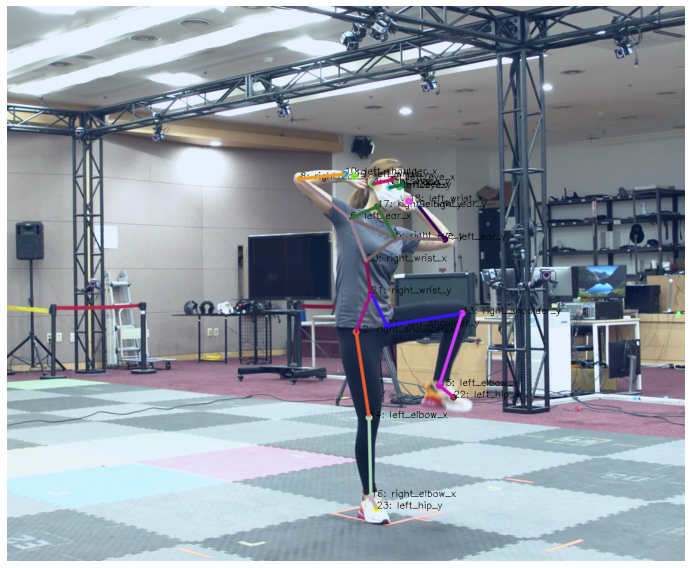

In [27]:
draw_keypoints(image, ys_[1]["keypoints"][0, :, :2].numpy(), edges)

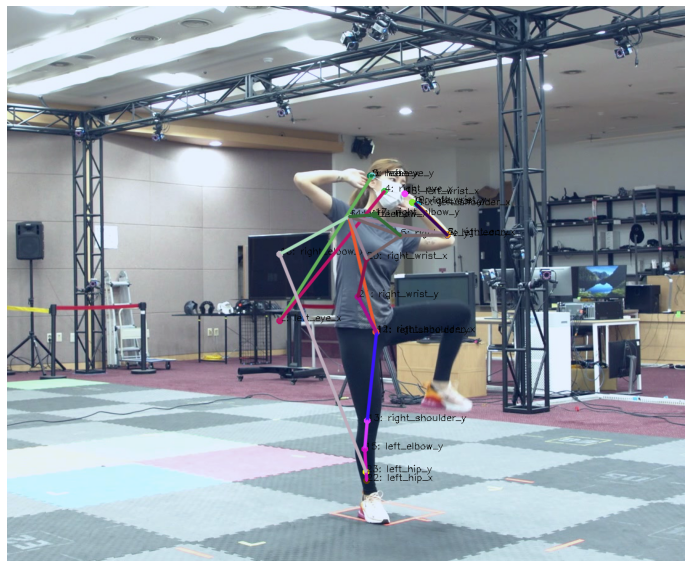

In [34]:
draw_keypoints(image, keypoints, edges)

In [38]:
(ys_[1]["keypoints"][0, :, :2] - keypoints).square().mean().sqrt()

tensor(111.0863)

In [28]:
transform = A.Compose(
    [
        A.Resize(1080, 1920),
    ],
    keypoint_params=A.KeypointParams(format="xy"),
)

In [29]:
# transform(image=np.zeros_like(image, dtype=np.uint8), keypoints=keypoints)
targets = transform(image=image, keypoints=keypoints)

In [30]:
torch.tensor(targets["keypoints"])

tensor([[1034.4778,  331.1019],
        [1028.5851,  331.1019],
        [ 773.2313,  613.0319],
        [1034.4778,  331.1019],
        [1069.8345,  360.7787],
        [1115.0123,  447.1114],
        [ 969.6572,  409.3408],
        [1246.6177,  445.7624],
        [1246.6177,  444.4135],
        [1156.2618,  385.0598],
        [1164.1188,  386.4087],
        [1046.2633,  635.9641],
        [1044.2991,  634.6152],
        [1020.7280,  807.2804],
        [ 967.6929,  409.3408],
        [1012.8708,  862.5873],
        [ 773.2313,  483.5330],
        [1040.3705,  406.6429],
        [1126.7980,  364.8256],
        [1148.4048,  382.3619],
        [1018.7638,  491.6267],
        [ 993.2284,  565.8188],
        [1018.7638,  923.2900],
        [1016.7995,  907.1026]])

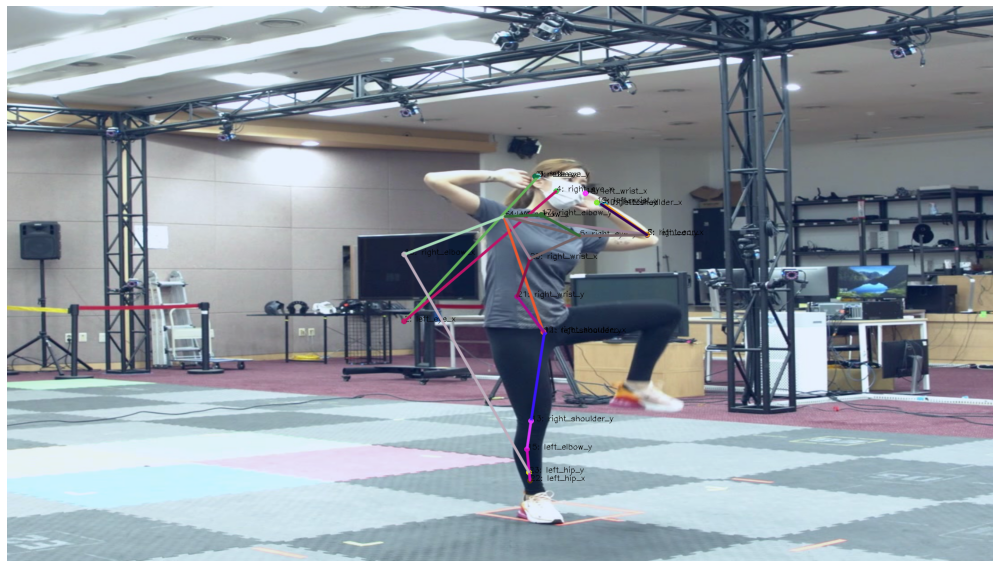

In [31]:
draw_keypoints(targets["image"], torch.tensor(targets["keypoints"]), edges)

In [32]:
torch.tensor(targets["keypoints"], dtype=torch.float32).flatten().numpy()

array([1034.4778 ,  331.10187, 1028.5851 ,  331.10187,  773.2313 ,
        613.0319 , 1034.4778 ,  331.10187, 1069.8345 ,  360.7787 ,
       1115.0123 ,  447.1114 ,  969.6572 ,  409.34082, 1246.6177 ,
        445.76242, 1246.6177 ,  444.41348, 1156.2618 ,  385.05978,
       1164.1188 ,  386.40872, 1046.2633 ,  635.96405, 1044.2991 ,
        634.6152 , 1020.72797,  807.2804 ,  967.69293,  409.34082,
       1012.87085,  862.58734,  773.2313 ,  483.53296, 1040.3705 ,
        406.64294, 1126.798  ,  364.82556, 1148.4048 ,  382.36188,
       1018.7638 ,  491.62668,  993.2284 ,  565.8188 , 1018.7638 ,
        923.29   , 1016.7995 ,  907.1026 ], dtype=float32)

In [33]:
df

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,...,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,...,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,...,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
3,001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,...,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
4,001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,...,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190,642-2-4-31-Z148_E-0000023.jpg,637.251052,781.342260,1117.135818,370.667301,1097.123228,330.642200,1095.455539,355.657874,1083.364600,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.997090,612.486105,616.404617,803.439462
4191,642-2-4-31-Z148_E-0000025.jpg,637.251052,781.342260,1117.135818,370.667301,1097.123228,330.642200,1095.455539,355.657874,1083.364600,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.997090,612.486105,616.404617,803.439462
4192,642-2-4-31-Z148_E-0000027.jpg,637.251052,781.342260,1117.135818,370.667301,1097.123228,330.642200,1095.455539,355.657874,1083.364600,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.997090,612.486105,616.404617,803.439462
4193,642-2-4-31-Z148_E-0000029.jpg,637.251052,781.342260,1117.135818,370.667301,1097.123228,330.642200,1095.455539,355.657874,1083.364600,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.997090,612.486105,616.404617,803.439462
